In [63]:
import os
import sys

path = ['..', 'CToxPred']
src_dir = os.path.abspath(os.path.join(*path))
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [64]:
import os
print(os.getcwd())

C:\Users\ADS_Lab\Desktop\JH\Paper_Replication\CToxPred\notebooks


In [65]:
import joblib
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

from pairwise_correlation import CorrelationThreshold
from CToxPred.utils import compute_fingerprint_features, compute_descriptor_features, compute_metrics
from CToxPred.hERG_model import hERGClassifier
from CToxPred.nav15_model import Nav15Classifier
from CToxPred.cav12_model import Cav12Classifier

### Load data

In [66]:
## hERG
eval_herg_set_60 = pd.read_csv("../data/raw/hERG/eval_set_herg_60.csv")
eval_herg_set_70 = pd.read_csv("../data/raw/hERG/eval_set_herg_70.csv")
## Nav1.5
eval_nav_set_60 = pd.read_csv("../data/raw/Nav1.5/eval_set_nav_60.csv")
eval_nav_set_70 = pd.read_csv("../data/raw/Nav1.5/eval_set_nav_70.csv")
## Cav1.2
eval_cav_set_60 = pd.read_csv("../data/raw/Cav1.2/eval_set_cav_60.csv")
eval_cav_set_70 = pd.read_csv("../data/raw/Cav1.2/eval_set_cav_70.csv")

In [52]:
eval_cav_set_70

,InChl Key,SMILES,Source,ChEMBL ID,PubChem CID,pIC50
0,UYZIPLMTFSGKAJ-OAHLLOKOSA-N,N[C@H](COCc1cc(C(F)(F)F)cc(C(F)(F)F)c1)c1ccccc1,ChEMBL,CHEMBL92818,NaN,6.23657
1,YVLZVIUUVUBKNC-QGZVFWFLSA-N,CN(CC(N)=O)[C@H](COCc1cc(C(F)(F)F)cc(C(F)(F)F)...,ChEMBL,CHEMBL327765,NaN,5.00000
2,FLNYLINBEZROPL-NSOVKSMOSA-N,COc1ccccc1CN[C@H]1C2CCN(CC2)[C@H]1C(c1ccccc1)c...,ChEMBL,CHEMBL16192,NaN,6.61979
3,KTQASNDGWLUTPN-UHFFFAOYSA-N,Cc1ccc(CN2CCC(n3c(O)nc4ccccc43)CC2)c(Cl)c1,ChEMBL,CHEMBL114484,NaN,5.87290
4,PAJSQNJPMJTKTN-UHFFFAOYSA-N,Cc1ccc2nc(O)n(C3CCN(Cc4cc5c(cc4Cl)OCO5)CC3)c2c1,ChEMBL,CHEMBL420863,NaN,5.76700
...,...,...,...,...,...,...
76,FTUDAMYKRYOOIG-UHFFFAOYSA-N,COC(=O)C1=CNC=C(C(=O)OC)C1c1ccc(Cl)c(Cl)c1,ChEMBL,CHEMBL602780,NaN,6.00000
77,ZUSRJOLABHKRGS-UHFFFAOYSA-N,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCC)C1c1ccc(OC)cc1OC,ChEMBL,CHEMBL2063635,NaN,6.00000
78,ODICPULKHOZXSO-UHFFFAOYSA-N,COC(=O)C1=C(C)N(C)C(C)=C(C(=O)OC)C1c1cccc(Cl)c1,ChEMBL,CHEMBL2063807,NaN,6.00000
79,AARJIBDJVXSJTN-UHFFFAOYSA-N,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1ccc(C)o1,ChEMBL,CHEMBL2063639,NaN,6.00000


In [67]:
eval_herg_set_70

,InChl Key,SMILES,Source,PubChem CID,pIC50
0,JPDCMOOBLLIEFK-UHFFFAOYSA-N,Fc1ccc(-c2cnn(CCc3cn[nH]c3)c2)cc1C(F)F,US Patent,NaN,5.686133
1,PKPIKMRNRASAMG-UHFFFAOYSA-N,COc1c(NC(=O)Nc2ccc(Oc3ccnc(Nc4ccccc4)c3)c3cccc...,US Patent,NaN,5.522879
2,APFLBUWSTCFNIE-UHFFFAOYSA-N,CNCC(Cc1cccs1)c1ccc2ccccc2c1,US Patent,NaN,5.387216
3,HGZIMTNVCYVDSN-UHFFFAOYSA-N,CC(C)n1c(NCC2CNCCO2)nc2c([N+](=O)[O-])c(Br)c(B...,US Patent,NaN,5.379864
4,MRAZBVXMLFFLEZ-UHFFFAOYSA-N,CNCC(Cc1ccccc1OC)c1ccc2ccccc2c1,US Patent,NaN,5.327902
...,...,...,...,...,...
468,DDHVVNWORMJVLB-UHFFFAOYSA-O,Fc1ccc2c(C3C[NH2+]CCC3F)c(C3CCCCCC3)[nH]c2c1,"Konda et al., 2019",NaN,5.270000
469,UTMPBYAPGSEZCC-UHFFFAOYSA-O,Fc1ccc2c(C3C[NH2+]CCC3F)c(C3=CNC=CC3)[nH]c2c1,"Konda et al., 2019",NaN,5.600000
470,VMCOPKACEUYYIT-UHFFFAOYSA-O,Fc1ccc(-c2[nH]c3cc(F)ccc3c2C2CCC[NH2+]C2)cc1,"Konda et al., 2019",NaN,5.890000
471,ZXZKBUDCPJISJW-UHFFFAOYSA-N,Cn1ccnc1C(=O)N1CCC(c2ccc(C(=O)N=C(N)N)cc2C(F)(...,"Konda et al., 2019",NaN,4.520000


### Assign labels

In [68]:
## Label the sets
eval_herg_set_60['Label'] = np.where(eval_herg_set_60['pIC50'] >= 5, 1, 0)
eval_herg_set_70['Label'] = np.where(eval_herg_set_70['pIC50'] >= 5, 1, 0)
## Label the sets
eval_nav_set_60['Label'] = np.where(eval_nav_set_60['pIC50'] >= 5, 1, 0)
eval_nav_set_70['Label'] = np.where(eval_nav_set_70['pIC50'] >= 5, 1, 0)
## Label the sets
eval_cav_set_60['Label'] = np.where(eval_cav_set_60['pIC50'] >= 5, 1, 0)
eval_cav_set_70['Label'] = np.where(eval_cav_set_70['pIC50'] >= 5, 1, 0)

In [70]:
eval_herg_set_70

,InChl Key,SMILES,Source,PubChem CID,pIC50,Label
0,JPDCMOOBLLIEFK-UHFFFAOYSA-N,Fc1ccc(-c2cnn(CCc3cn[nH]c3)c2)cc1C(F)F,US Patent,NaN,5.686133,1
1,PKPIKMRNRASAMG-UHFFFAOYSA-N,COc1c(NC(=O)Nc2ccc(Oc3ccnc(Nc4ccccc4)c3)c3cccc...,US Patent,NaN,5.522879,1
2,APFLBUWSTCFNIE-UHFFFAOYSA-N,CNCC(Cc1cccs1)c1ccc2ccccc2c1,US Patent,NaN,5.387216,1
3,HGZIMTNVCYVDSN-UHFFFAOYSA-N,CC(C)n1c(NCC2CNCCO2)nc2c([N+](=O)[O-])c(Br)c(B...,US Patent,NaN,5.379864,1
4,MRAZBVXMLFFLEZ-UHFFFAOYSA-N,CNCC(Cc1ccccc1OC)c1ccc2ccccc2c1,US Patent,NaN,5.327902,1
...,...,...,...,...,...,...
468,DDHVVNWORMJVLB-UHFFFAOYSA-O,Fc1ccc2c(C3C[NH2+]CCC3F)c(C3CCCCCC3)[nH]c2c1,"Konda et al., 2019",NaN,5.270000,1
469,UTMPBYAPGSEZCC-UHFFFAOYSA-O,Fc1ccc2c(C3C[NH2+]CCC3F)c(C3=CNC=CC3)[nH]c2c1,"Konda et al., 2019",NaN,5.600000,1
470,VMCOPKACEUYYIT-UHFFFAOYSA-O,Fc1ccc(-c2[nH]c3cc(F)ccc3c2C2CCC[NH2+]C2)cc1,"Konda et al., 2019",NaN,5.890000,1
471,ZXZKBUDCPJISJW-UHFFFAOYSA-N,Cn1ccnc1C(=O)N1CCC(c2ccc(C(=O)N=C(N)N)cc2C(F)(...,"Konda et al., 2019",NaN,4.520000,0


### Load models

In [90]:
# def _generate_predictions(smiles_list: List[str]) -> pd.DataFrame:
#     """
#     Generates predictions for hERG, Nav1.5, and Cav1.2 targets based on the provided list of SMILES.
# 
#     This function processes the input SMILES list and computes fingerprint and descriptor features for each compound.
#     Then, it loads pre-trained models for hERG, Nav1.5, and Cav1.2 targets, and predicts the activity of each compound
#     for these targets using the respective models. The predictions are saved to a CSV file named 'predictions.csv'
#     with columns: 'SMILES', 'hERG', 'Nav1.5', and 'Cav1.2'. The 'hERG', 'Nav1.5', and 'Cav1.2' columns contain the
#     binary predictions (0 or 1) for each target, representing non-toxic (negative class) or toxic (positive class)
#     compounds, respectively.
# 
#     Parameters:
#         smiles_list: List[str] 
#             A list containing SMILES strings of chemical compounds.
# 
#     Returns:
#         pd.DataFrame: 
#             A DataFrame with 4 columns {'SMILES', 'hERG', 'Nav1.5', Cav1.2'} containing the predictions for each target 
#             of the input SMILES strings .
#     """
#     # Compute features
#     print('>>>>>>> Calculate Features <<<<<<<')
#     fingerprints = compute_fingerprint_features(smiles_list)
#     descriptors = compute_descriptor_features(smiles_list)
#     # Process hERG
#     print('>>>>>>> Predict hERG <<<<<<<')
#     hERG_fingerprints = fingerprints
#     ## Load model
#     hERG_predictor = hERGClassifier(1905, 2)
#     path = ['..','CToxPred', 'models', 'model_weights', 'hERG',
#             '_herg_checkpoint.model']
#     hERG_predictor.load(os.path.join(*path))
#     device = torch.device('cpu')
#     hERG_predictions = hERG_predictor(
#         torch.from_numpy(hERG_fingerprints).float().to(device)).argmax(1).cpu()
# 
#     # Process Nav1.5
#     print('>>>>>>> Predict Nav1.5 <<<<<<<')
#     nav15_fingerprints = fingerprints
#     nav15_descriptors = descriptors
#     ## Load preprocessing pipeline
#     path = ['..','CToxPred', 'models', 'decriptors_preprocessing', 'Nav1.5',
#             'nav_descriptors_preprocessing_pipeline.sav']
#     descriptors_transformation_pipeline = joblib.load(os.path.join(*path))
#     nav15_descriptors = descriptors_transformation_pipeline.transform(
#         nav15_descriptors)
#     nav15_features = np.concatenate((nav15_fingerprints, nav15_descriptors),
#                                     axis=1)
#     ## Load model
#     nav15_predictor = Nav15Classifier(2454, 2)
#     path = ['..', 'CToxPred', 'models', 'model_weights', 'Nav1.5',
#             '_nav15_checkpoint.model']
#     nav15_predictor.load(os.path.join(*path))
#     nav15_predictions = nav15_predictor(
#         torch.from_numpy(nav15_features).float().to(device)).argmax(1).cpu()
# 
#     # Process Cav1.2
#     print('>>>>>>> Predict Cav1.2 <<<<<<<')
#     cav12_fingerprints = fingerprints
#     cav12_descriptors = descriptors
#     ## Load preprocessing pipeline
#     path = ['..', 'CToxPred', 'models', 'decriptors_preprocessing', 'Cav1.2',
#             'cav_descriptors_preprocessing_pipeline.sav']
#     descriptors_transformation_pipeline = joblib.load(os.path.join(*path))
#     cav12_descriptors = descriptors_transformation_pipeline.transform(
#         cav12_descriptors)
#     cav12_features = np.concatenate((cav12_fingerprints, cav12_descriptors),
#                                     axis=1)
#     ## Load model
#     cav12_predictor = Cav12Classifier(2586, 2)
#     path = ['..', 'CToxPred', 'models', 'model_weights', 'Cav1.2',
#             '_cav12_checkpoint.model']
#     cav12_predictor.load(os.path.join(*path))
#     cav12_predictions = cav12_predictor(
#         torch.from_numpy(cav12_features).float().to(device)).argmax(1).cpu()
# 
#     # Generate output
#     results = pd.DataFrame({'SMILES': smiles_list, 'hERG': hERG_predictions,
#                             'Nav1.5': nav15_predictions,
#                             'Cav1.2': cav12_predictions})
#     return results



   


def _generate_predictions(smiles_list: List[str]) -> pd.DataFrame:
    """
    Generates predictions for hERG, Nav1.5, and Cav1.2 targets based on the provided list of SMILES.

    This function processes the input SMILES list and computes fingerprint and descriptor features for each compound.
    Then, it loads pre-trained models for hERG, Nav1.5, and Cav1.2 targets, and predicts the activity of each compound
    for these targets using the respective models. The predictions are saved to a CSV file named 'predictions.csv'
    with columns: 'SMILES', 'hERG', 'Nav1.5', and 'Cav1.2'. The 'hERG', 'Nav1.5', and 'Cav1.2' columns contain the
    binary predictions (0 or 1) for each target, representing non-toxic (negative class) or toxic (positive class)
    compounds, respectively.

    Parameters:
        smiles_list: List[str] 
            A list containing SMILES strings of chemical compounds.

    Returns:
        pd.DataFrame: 
            A DataFrame with 4 columns {'SMILES', 'hERG', 'Nav1.5', Cav1.2'} containing the predictions for each target 
            of the input SMILES strings.
    """
    # Compute features
    print('>>>>>>> Calculate Features <<<<<<<')
    fingerprints = compute_fingerprint_features(smiles_list)
    descriptors = compute_descriptor_features(smiles_list)

    device = torch.device('cpu')

    # Process hERG
    print('>>>>>>> Predict hERG <<<<<<<')
    hERG_fingerprints = fingerprints
    # Load model
    hERG_predictor = hERGClassifier(1905, 2)
    path = ['..', 'CToxPred', 'models', 'model_weights', 'hERG', '_herg_checkpoint.model']
    # path = ['..', 'pretrain', 'best_hERG_classifier_trained.model']
    
    hERG_predictor.load(os.path.join(*path))
    hERG_predictions = hERG_predictor(torch.from_numpy(hERG_fingerprints).float().to(device)).argmax(1).cpu()
    hERG_y_score = hERG_predictor(torch.from_numpy(hERG_fingerprints).float().to(device)).softmax(1).cpu().detach().numpy()

    # Process Nav1.5
    print('>>>>>>> Predict Nav1.5 <<<<<<<')
    nav15_fingerprints = fingerprints
    nav15_descriptors = descriptors
    # Load preprocessing pipeline
    path = ['..', 'CToxPred', 'models', 'decriptors_preprocessing', 'Nav1.5', 'nav_descriptors_preprocessing_pipeline.sav']
    descriptors_transformation_pipeline = joblib.load(os.path.join(*path))
    nav15_descriptors = descriptors_transformation_pipeline.transform(nav15_descriptors)
    nav15_features = np.concatenate((nav15_fingerprints, nav15_descriptors), axis=1)
    # Load model
    nav15_predictor = Nav15Classifier(2454, 2)
    path = ['..', 'CToxPred', 'models', 'model_weights', 'Nav1.5', '_nav15_checkpoint.model']
    nav15_predictor.load(os.path.join(*path))
    nav15_predictions = nav15_predictor(torch.from_numpy(nav15_features).float().to(device)).argmax(1).cpu()
    nav15_y_score = nav15_predictor(torch.from_numpy(nav15_features).float().to(device)).softmax(1).cpu().detach().numpy()

    # Process Cav1.2
    print('>>>>>>> Predict Cav1.2 <<<<<<<')
    cav12_fingerprints = fingerprints
    cav12_descriptors = descriptors
    # Load preprocessing pipeline
    path = ['..', 'CToxPred', 'models', 'decriptors_preprocessing', 'Cav1.2', 'cav_descriptors_preprocessing_pipeline.sav']
    descriptors_transformation_pipeline = joblib.load(os.path.join(*path))
    cav12_descriptors = descriptors_transformation_pipeline.transform(cav12_descriptors)
    cav12_features = np.concatenate((cav12_fingerprints, cav12_descriptors), axis=1)
    # Load model
    cav12_predictor = Cav12Classifier(2586, 2)
    path = ['..', 'CToxPred', 'models', 'model_weights', 'Cav1.2', '_cav12_checkpoint.model']
    cav12_predictor.load(os.path.join(*path))
    cav12_predictions = cav12_predictor(torch.from_numpy(cav12_features).float().to(device)).argmax(1).cpu()
    cav12_y_score = cav12_predictor(torch.from_numpy(cav12_features).float().to(device)).softmax(1).cpu().detach().numpy()

    # Generate output
    results = pd.DataFrame({
        'SMILES': smiles_list, 
        'hERG': hERG_predictions,
        'Nav1.5': nav15_predictions,
        'Cav1.2': cav12_predictions,
        'hERG_y_score': hERG_y_score[:, 1],  # The probability for the positive class
        'Nav1.5_y_score': nav15_y_score[:, 1],  # The probability for the positive class
        'Cav1.2_y_score': cav12_y_score[:, 1]   # The probability for the positive class
    })
    return results



### Initialize confusion matrix

In [83]:
def draw_confusion_matrix(ground_truth, predicted):
    ## Compute confusion matrix
    matrix = confusion_matrix(ground_truth, predicted)
    percentages = (matrix.T/matrix.sum(axis=1)).T
    ## Set cell format
    flattened_counts = [value for value in matrix.flatten()]
    flattened_percentages = ["{0:.2%}".format(value) for value in percentages.flatten()]
    labels = [f"{percentage}\n{value}" for value, percentage in 
                                      zip(flattened_counts,flattened_percentages)]
    labels = np.asarray(labels).reshape(matrix.shape[0],matrix.shape[0])
    ## create dataframe to set x/y-axis labels with focus on percentage
    percentDataframe = pd.DataFrame(percentages*100, 
                           columns = ['Non-blocker','Blocker'],
                           index = ['Non-blocker', 'Blocker'])
    ## Plot
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    sns.set_context('paper', font_scale=1.0)
    width = 7
    height = width / 1.6
    plt.figure(figsize=(width, height))
    ax = plt.axes()
    
    sns.heatmap(percentDataframe, annot = labels, fmt='',cmap= 'Blues', ax=ax, vmin=0, vmax=100, cbar_kws={'label': 'Accuracy'})
    ax.yaxis.set_tick_params(rotation=0)
    ax.set(xlabel='Predicted label', ylabel='True label')
    ax.title.set_text('Accuracy = {0:.1%}'.format(sum(1 for x,y in zip(ground_truth,predicted) if x == y) / len(ground_truth)))
    plt.show()

## Make cardiotoxicity predictions

In [ ]:
predictions = _generate_predictions(eval_herg_set_70['SMILES'])

>>>>>>> Calculate Features <<<<<<<


 34%|███▍      | 161/473 [00:04<00:08, 38.40it/s]


In [86]:
from sklearn.metrics import roc_auc_score

# 예측 결과
predictions = _generate_predictions(eval_herg_set_70['SMILES'])

# pIC50 값을 이진 라벨로 변환
y_true_cav12 = (eval_herg_set_70['pIC50'] >= 5).astype(int)  # 0.5 이상이면 1, 미만이면 0

# Cav1.2 예측 확률값
y_score_cav12 = predictions['hERG']

# Cav1.2에 대한 AUC 계산
auc_cav12 = roc_auc_score(y_true_cav12, y_score_cav12)

# 출력
print(f"Cav1.2 AUC: {auc_cav12:.4f}")


>>>>>>> Calculate Features <<<<<<<


 51%|█████     | 242/473 [00:05<00:03, 71.00it/s]

C:\Users\ADS_Lab\anaconda3\envs\ctoxpred\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\ADS_Lab\anaconda3\envs\ctoxpred\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 62%|██████▏   | 292/473 [00:05<00:04, 36.77it/s]

C:\Users\ADS_Lab\anaconda3\envs\ctoxpred\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\ADS_Lab\anaconda3\envs\ctoxpred\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 473/473 [00:08<00:00, 53.86it/s]


>>>>>>> Predict hERG <<<<<<<
>>>>>>> Predict Nav1.5 <<<<<<<
>>>>>>> Predict Cav1.2 <<<<<<<
Cav1.2 AUC: 0.8069


>>>>>>> Calculate Features <<<<<<<


 51%|█████     | 242/473 [00:05<00:02, 95.74it/s]

C:\Users\ADS_Lab\anaconda3\envs\ctoxpred\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\ADS_Lab\anaconda3\envs\ctoxpred\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 62%|██████▏   | 292/473 [00:05<00:04, 40.94it/s]

C:\Users\ADS_Lab\anaconda3\envs\ctoxpred\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\ADS_Lab\anaconda3\envs\ctoxpred\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 473/473 [00:08<00:00, 54.72it/s]


>>>>>>> Predict hERG <<<<<<<
>>>>>>> Predict Nav1.5 <<<<<<<
>>>>>>> Predict Cav1.2 <<<<<<<


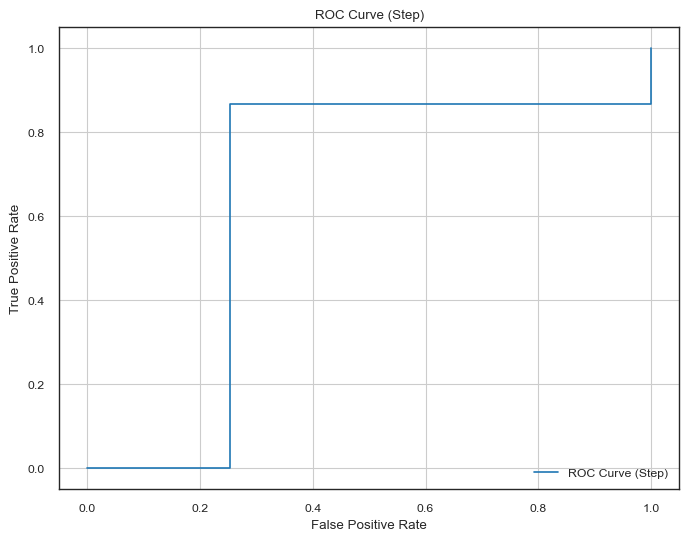

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np

# 예측 결과
predictions = _generate_predictions(eval_herg_set_70['SMILES'])

# pIC50 값을 이진 라벨로 변환
y_true_cav12 = (eval_herg_set_70['pIC50'] >= 5).astype(int)  # 0.5 이상이면 1, 미만이면 0

# Cav1.2 예측 확률값
y_score_cav12 = predictions['hERG']

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_true_cav12, y_score_cav12)

# 계단식으로 변하는 ROC 그래프
plt.figure(figsize=(8, 6))

# 계단식 그래프 그리기
plt.step(fpr, tpr, where='post', label='ROC Curve (Step)')

# x, y축 레이블과 제목 추가
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Step)')

# AUC 값도 출력
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [79]:
predictions

,SMILES,hERG,Nav1.5,Cav1.2,hERG_y_score,Nav1.5_y_score,Cav1.2_y_score
0,Fc1ccc(-c2cnn(CCc3cn[nH]c3)c2)cc1C(F)F,1,0,1,0.731059,0.269581,0.681306
1,COc1c(NC(=O)Nc2ccc(Oc3ccnc(Nc4ccccc4)c3)c3cccc...,1,1,1,0.731059,0.708274,0.731058
2,CNCC(Cc1cccs1)c1ccc2ccccc2c1,1,1,0,0.731059,0.730820,0.269459
3,CC(C)n1c(NCC2CNCCO2)nc2c([N+](=O)[O-])c(Br)c(B...,1,1,0,0.731059,0.731058,0.269332
4,CNCC(Cc1ccccc1OC)c1ccc2ccccc2c1,1,1,1,0.731059,0.729489,0.662153
...,...,...,...,...,...,...,...
468,Fc1ccc2c(C3C[NH2+]CCC3F)c(C3CCCCCC3)[nH]c2c1,1,1,0,0.731059,0.580364,0.394157
469,Fc1ccc2c(C3C[NH2+]CCC3F)c(C3=CNC=CC3)[nH]c2c1,1,0,1,0.731059,0.269000,0.687097
470,Fc1ccc(-c2[nH]c3cc(F)ccc3c2C2CCC[NH2+]C2)cc1,1,0,1,0.731059,0.285096,0.708879
471,Cn1ccnc1C(=O)N1CCC(c2ccc(C(=O)N=C(N)N)cc2C(F)(...,1,1,1,0.731059,0.728552,0.723077


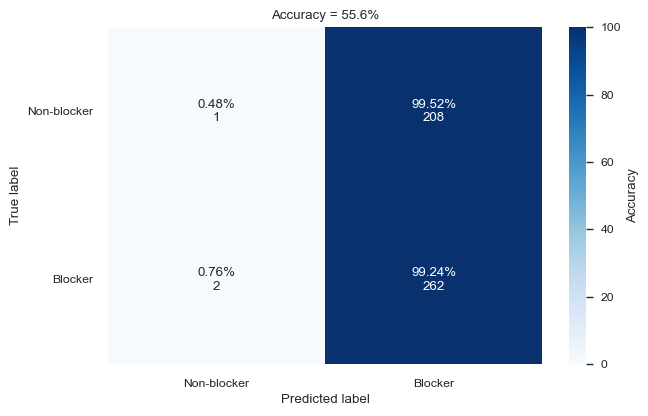

In [80]:
draw_confusion_matrix(eval_herg_set_70['Label'],predictions['hERG'])

In [81]:
compute_metrics(eval_herg_set_60['Label'],predictions['hERG'])

Binary classification performace metrics:


ValueError: Found input variables with inconsistent numbers of samples: [250, 473]